**SCROLL TO BOTTOM TO RUN CODE AND ACCESS OUTPUTS**

In [8]:
import pytesseract as pt
pt.pytesseract.tesseract_cmd = r"C:\Program Files (x86)\Tesseract-OCR\tesseract.exe"
from PIL import Image
import cv2
import numpy as np
from matplotlib import pyplot as plt
import copy
import pandas as pd

In [121]:
pt.image_to_string(cv2.cvtColor(cv2.imread('A.jpg'), cv2.COLOR_BGR2GRAY))
_, thresh = cv2.threshold(cv2.imread('A.jpg'),127,255,cv2.THRESH_BINARY)
pt.image_to_string(thresh[:400,:])

''

In [83]:
class Puzzle:
    
    def __init__(self, page_path, corner_path):
        self.page_pic = cv2.cvtColor(cv2.imread(page_path), cv2.COLOR_BGR2GRAY)
        #self.corners = np.array([[240,2120], [1840,2115], [1890,3800], [150,3830]])
        self.corners = np.loadtxt(corner_path, delimiter=',', dtype=int)
        self.flatgrid = self.flatten(self.page_pic, self.corners, imgsize=(1000,1000))
        self.blacks = self.black_coords(self.flatgrid)
        self.crossgrid, self.cluelist, self.acrossnums, self.downnums = self.blacks_to_grid(self.blacks)
        self.smallboxes = self.all_smallboxes(self.flatgrid, imgsize=1000)
        self.acrossimg, self.downimg = self.getAcross(self.page_pic, self.corners)
        self.cluelist = self.process_ocr(self.acrossimg, 'ACROSS', self.acrossnums, self.cluelist)
        self.cluelist = self.process_ocr(self.downimg, 'DOWN', self.downnums, self.cluelist)
        self.chargrid = self.init_chargrid()
    
    def flatten(self, page_pic, corners, imgsize=(1000,1000)): 
        '''
        page_pic is the original full-page image taken by the user
        corners is a 2D nparray, lists pixel coordinates of the crossgrid's 4 corners
            First row is top left corner, proceed counterclockwise
        imgsize is the side pixel length of the returned flattened image
        '''
        newCorners = np.array([[0,0], [imgsize[0]-1, 0], [imgsize[0]-1, imgsize[1]-1], [0, imgsize[1]-1]])
        h, status = cv2.findHomography(corners, newCorners)
        return cv2.warpPerspective(page_pic, h, imgsize)

    def corner_crop(self, flatgrid, corners): #corners is 2D nparray. 4 rows, one for each coordinate. 
        x, y, w, h = cv2.boundingRect(corners)
        smallimg = flatgrid[y:y+h, x:x+w].copy()

        corners -= corners.min(axis=0)
        mask = np.zeros(smallimg.shape[:2], np.uint8)
        cv2.drawContours(mask, [corners], -1, (255,255,255), -1, cv2.LINE_AA)

        dst = cv2.bitwise_and(smallimg, smallimg, mask=mask)

        return dst

    def get_smallbox(self, flatgrid, i, j, imgsize=1000): 
        '''
        flatgrid is the transformed crossgrid image (must have square dimensions)
        i, j are coordinates of the desired smallbox
        imgsize is the side length of flatgrid
        '''
        i1, i2 = int(i * imgsize / 15), int((i+1) * imgsize / 15)
        j1, j2 = int(j * imgsize / 15), int((j+1) * imgsize / 15)
        smallCorners = np.array([[i1, j1], [i2, j1], [i2, j2], [i1, j2]])
        smallImg = self.corner_crop(flatgrid, smallCorners)
        return smallImg

    def all_smallboxes(self, flatgrid, imgsize=1000): #returns dictionary mapping coordinate to smallbox. 
        allsmalls = {}
        for i in range(15):
            for j in range(15):
                allsmalls[(i,j)] = self.get_smallbox(flatgrid, i, j, imgsize)
        return allsmalls

    def black_coords(self, flatgrid): #flatgrid is the transformed crossgrid image
        data = np.zeros((15, 15))
        for i in range(15):
            for j in range(15):
                data[j, i] = self.get_smallbox(flatgrid, i, j).mean()

        sortedData = np.msort(data.flatten()) #sorted mean values
        shifted = np.append(sortedData, sortedData[-1]) #shifted has something at end of array
        diffs = shifted - np.insert(sortedData, 0, sortedData[0])
        numblack = np.argmax(diffs) #tells us how many black boxes there are
        threshold = np.mean(sortedData[numblack - 1:numblack+1])
        blackboxes = np.where(data < threshold)
        return np.concatenate((blackboxes[0].reshape(-1,1), blackboxes[1].reshape(-1,1)), axis=1)

    def blacks_to_grid(self, blacks): #blacks is the list of black grid coordinates
        printgrid = np.zeros((15, 15))
        printgrid[blacks[:,0],blacks[:,1]] = 255
        refgrid = copy.deepcopy(printgrid)
        counter, cluelist = 1, {}
        acrossnums, downnums = [], []
        for i in range(15):
            for j in range(15):
                down, across = False, False
                if i==0 and refgrid[i,j]==0:
                    down = True
                if j==0 and refgrid[i,j]==0:
                    across = True
                if j > 0 and refgrid[i,j-1] == 255 and refgrid[i,j] == 0:
                    across = True
                if i > 0 and refgrid[i-1,j] == 255 and refgrid[i,j] == 0:
                    down = True
                if down:
                    below = refgrid[i:15,j]
                    if len(np.where(below==255)[0]) == 0:
                        word_len = 15 - i
                    else: word_len = np.where(below==255)[0][0]
                    cluelist[str(counter)+' DOWN'] = ['?' * word_len]
                    downnums.append(counter)
                if across: 
                    below = refgrid[i,j:15]
                    if len(np.where(below==255)[0]) == 0:
                        word_len = 15 - j
                    else: word_len = np.where(below==255)[0][0]
                    cluelist[str(counter)+' ACROSS'] = ['?' * word_len]
                    acrossnums.append(counter)
                if down or across:
                    printgrid[i,j] = counter
                    counter += 1
        return printgrid, cluelist, sorted(acrossnums), sorted(downnums)

    def getAcross(self, img, corners):

        corners = np.fliplr(corners)

        def getCorner(corns, bottom_ind, top_ind, ratio):
            x1, y1, x2, y2 = np.stack((corns[bottom_ind], corns[top_ind])).flatten()
            x = int(x2 + ratio * (x1 - x2))
            y = int(y2 + ratio * (y1 - y2))
            return np.array([y, x])

        acrossCorners = -np.ones((4, 2)).astype(int)
        param_sets = [(0, -1, 2.04), (1, 2, 2.04), (1, 2, 1.055), (0, -1, 1.055)]
        for i, param_set in enumerate(param_sets):
            bottom_ind, top_ind, ratio = param_set
            acrossCorners[i,:] = getCorner(corners, bottom_ind, top_ind, ratio)

        new_corns = np.concatenate((np.fliplr(acrossCorners[0:2,:]), corners[2:4,:]))
        downCorners = -np.ones((4, 2)).astype(int)
        r1, r2 = 1.035, 1.69
        param_sets = [(1, 0, r1), (1, 0, r2), (2, 3, r2), (2, 3, r1)]
        for i, param_set in enumerate(param_sets):
            bottom_ind, top_ind, ratio = param_set
            downCorners[i,:] = getCorner(new_corns, bottom_ind, top_ind, ratio)

        acrosses = self.flatten(img, acrossCorners, imgsize=(1000,1000))
        downs = self.flatten(img, downCorners, imgsize=(710,2340))

        return acrosses, downs

    def process_ocr(self, img, direction, cluenums, cluelist): #modifies cluelist in-place
        cluenums = copy.deepcopy(cluenums)
        text = pt.image_to_string(img).replace("'","")
        no_newlines = text.split(direction)[1].split('\n')
        nonempty = list(filter(lambda x : x.strip() != '', no_newlines))

        def get_prefix(line):
            prefix = line.split(')')[0]
            if (line.find(')') in (1, 2)) and prefix.isnumeric():
                return int(prefix), line[len(prefix)+1:].strip()
            else: return -1, ''

        prevnum = -1
        for line in nonempty:
            cluenum, txt = get_prefix(line)
            if cluenum == -1:
                if prevnum != -1:
                    cluelist[str(prevnum) + ' ' + direction][1] += ' ' + line
            else: 
                try: nextclue = cluenums.pop(0)
                except IndexError: assert False, 'Extra clue at ' + str(cluenum) + direction
                assert cluenum == nextclue, "Can't read clue: " + line
                cluelist[str(cluenum) + ' ' + direction].append(txt)
                prevnum = cluenum

        assert cluenums == [], 'Not all clues were found for direction ' + direction
        return cluelist
    
    def init_chargrid(self):
        chars = np.empty((15,15), dtype=str)
        chars[:] = '?'
        chars[np.where(self.crossgrid==255)] = ' '
        return chars
        
    def save_display_csv(self, filename='cluedata.csv'):
        returner = pd.DataFrame(columns=['dir', 'key', 'clue'])
        for i, clueID in enumerate(self.cluelist.keys()):
            returner.loc[i] = [clueID.split()[1].lower(), clueID.split()[0], self.cluelist[clueID][1]]
        returner.loc[200] = ['size', '', 15]
        charstring = ''
        for entry in self.chargrid.flatten():
            if entry == ' ': charstring += ' '
            elif entry == '?': charstring += '_'
            else: charstring += entry
        returner.loc[300] = ['letters','', charstring]
        returner.to_csv(filename, index=False)
    
    def find_clueID(self, y, x):
        assert self.crossgrid[y,x] != 255, "can't find clueIDs of black box."
        y_down, x_across = y, x
        while y_down > 0 and self.crossgrid[y_down-1, x] != 255:
            y_down -= 1
        while x_across > 0 and self.crossgrid[y, x_across-1] != 255:
            x_across -= 1
        y_pos, x_pos = y - y_down, x - x_across
        y_id = str(int(self.crossgrid[y_down,x])) + ' DOWN'
        x_id = str(int(self.crossgrid[y,x_across])) + ' ACROSS'
        
        return y_id, y_pos, x_id, x_pos
    
    def add_letter(self, letter, y, x, conflict='exception'): #updates self.chargrid, self.cluelist
        assert len(letter) == 1 and letter.isalpha(), 'Letter must be 1 digit and isalpha.'
        assert self.chargrid[y,x] != ' ', 'Cannot set letter for black cell.'
        if conflict == 'ignore':
            if self.chargrid[y,x] not in ('?', letter): return
        elif conflict == 'exception':
            assert self.chargrid[y,x] in ('?', letter), 'Cannot override existing letter.'
        else: assert conflict == 'override', 'Conflict behavior must be exception, ignore, or override'
        self.chargrid[y,x] = letter
        
        y_id, y_pos, x_id, x_pos = self.find_clueID(y, x)
        prev_solution = self.cluelist[y_id][0]
        self.cluelist[y_id][0] = prev_solution[:y_pos] + letter + prev_solution[y_pos+1:]
        prev_solution = self.cluelist[x_id][0]
        self.cluelist[x_id][0] = prev_solution[:x_pos] + letter + prev_solution[x_pos+1:]
        
    def find_cell(self, clueID, pos): #returns y, x of the corresponding cell
        cluenum, direction = clueID.split()
        cluenum = int(cluenum)
        assert np.where(self.crossgrid == cluenum)[0].shape[0] == 1, 'Strange error in find_cell'
        y, x = np.where(self.crossgrid == cluenum)
        y, x = y[0], x[0]
        if direction == 'ACROSS': x += pos
        elif direction == 'DOWN': y += pos
        else: assert False, 'Bad clueID in find_cell'
        return y, x
        
    def add_word(self, word, clueID, conflict='ignore'):
        '''
        Updates [self.cluelist] and [self.chargrid].
        [word] is the solution that's being added. String. 
        [clueID] is the clueID of the word being changed. String. 
        Conflicts occur when we attempt to *change* an already-solved cell.
            'override': replace any existing letters.
            'exception': restore the previous solution and raise an exception
            'ignore': only add the non-conflicting letters
        Example: add_word('FAST', '31 ACROSS')
        '''
        backup = copy.deepcopy((self.cluelist, self.chargrid))
        assert len(self.cluelist[clueID][0]) == len(word), 'Solution length is incorrect.'
        assert clueID in self.cluelist.keys(), 'Given clueID is not valid.'
        try:
            for pos, letter in enumerate(word):
                y, x = self.find_cell(clueID, pos)
                self.add_letter(letter, y, x, conflict=conflict)
        except:
            self.cluelist, self.chargrid = backup
            raise

In [106]:
#import Puzzle
import httplib2, re

class DictionaryTool:

    def __init__(self, cluelist):
        self.answerlist = self.get_answers(cluelist)

    """ helper((a,b)) returns a tuple of clues linked to a tuple list [(x,y),...] where
        x is the predicted answer and y is the probability that it
        is correct for each clue"""
    def helper(self, tup):
        x=tup[1].strip()
        x=x.replace(' ','+')
        y=tup[0].strip()
        length = str(len(y))
        y=y.replace('?',"%3F")
        pat = re.compile('<div class="solver-cell">(.+?)</div>')
        http = httplib2.Http()
        _, body = http.request("https://www.dictionary.com/e/crosswordsolver/?query="+x+"&pattern=" + y + "&l=" + length)
        seclist = pat.findall(body.decode('ISO-8859-1'))
        tuplist = []
        temptup = ("","")
        for i in range(0,len(seclist)):
            if i > 2*2: break
            if i%2==0:
                temptup = (seclist[i],0)
            else:
                thisone = seclist[i]
                temptup = (temptup[0],int(thisone[:len(thisone)-1]))
                tuplist = tuplist + [temptup]
        return tuplist
            

    """ get_answers(clues) returns a dictionary of crossword number linked to tuples (x,y) where
        x is the predicted answer and y is the probability that it
        is correct for each clue. REQUIRES: clues is a dictionary {question # : (clue,length)}"""
    def get_answers(self, clues):
        keys = clues.keys()
        acc_dict = {}
        for key in keys:
            acc_dict[key] = self.helper(clues[key])
        return acc_dict

In [107]:
page_path = 'pic4.jpg'
corner_path = 'points4.csv'

print('Reading grid and clues...')
puzzle5 = Puzzle(page_path, corner_path)
print('Reading handwriting...')
#Read handwriting, make any necessary updates to the puzzle. 
print('Solving clues...')
answerlist = DictionaryTool(puzzle5.cluelist).answerlist
print('Solving crossword puzzle...')

Reading grid and clues...
Reading handwriting...
Solving clues...
Solving crossword puzzle...


In [108]:
answerlist

{'1 DOWN': [('FEW', 95), ('TOT', 82)],
 '1 ACROSS': [('FINDS', 95), ('DTCTS', 85)],
 '2 DOWN': [('IRA', 60), ('WHO', 60)],
 '3 DOWN': [('NUS', 95), ('LPS', 56)],
 '4 DOWN': [('DPHIL', 95), ('ORALS', 60)],
 '5 DOWN': [('STEREOS', 95), ('ADAPTOR', 60)],
 '6 DOWN': [('SEW', 95), ('EYE', 60)],
 '6 ACROSS': [('LANES', 60), ('SPLIT', 44)],
 '7 DOWN': [('PRO', 60), ('OWL', 60)],
 '8 DOWN': [('LIMBS', 95), ('NESTS', 60)],
 '9 DOWN': [('ICARUS', 95), ('ELPASO', 60)],
 '10 DOWN': [('TANAGER', 95), ('QUETZAL', 60)],
 '11 DOWN': [('SECONDSTORY', 20), ('HIDINGPLACE', 20)],
 '11 ACROSS': [('CPA', 95), ('TEE', 60)],
 '12 DOWN': [('PAYEE', 95), ('PAYTO', 60)],
 '13 DOWN': [('ARCED', 95), ('SPEAR', 60)],
 '14 ACROSS': [('ERUPT', 60), ('SPEWS', 60)],
 '15 ACROSS': [('ERICA', 60), ('LUCCI', 60)],
 '16 ACROSS': [('OAR', 95), ('RIM', 42)],
 '17 ACROSS': [],
 '18 DOWN': [('CORNEA', 95), ('RETINA', 88)],
 '19 ACROSS': [('NYC', 60), ('ART', 60)],
 '20 ACROSS': [('IRE', 95), ('ALI', 20)],
 '21 ACROSS': [('BRA'

In [85]:
import copy
import numpy as np

puzzle = copy.deepcopy(puzzle5)
answers = copy.deepcopy(answerlist)


def prioritize(answers):
    priority = {}
    for key in answers.keys():
        num1 = answerlist[key]
        if len(num1) == 0:
            priority[key] = 0
        elif len(num1) == 1:
            priority[key] = num1[0][1]
        else: 
            priority[key] = num1[0][1] - num1[1][1]
    return priority


while len(answers) > 0:
    priority = prioritize(answers)
    highest = max(priority, key=priority.get)
    if len(answers[highest]) == 0:
        del answers[highest]
        continue
    word = answers[highest][0][0]
    try: 
        puzzle.add_word(word, highest, conflict='exception')
    except: 
        pass
    del answers[highest]

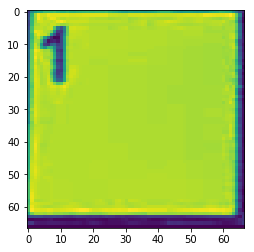

In [124]:
plt.imshow(puzzle.smallboxes[0,0])

In [102]:
wheres = np.where(puzzle.chargrid == '?')
coords = list(zip(wheres[0], wheres[1]))

for coord in coords: 
    x_list, y_list = {},{}
    y_id, y_pos, x_id, x_pos = puzzle.find_clueID(coord[0], coord[1])
    x_list[x_id] = puzzle.cluelist[x_id]
    y_list[y_id] = puzzle.cluelist[y_id]
    x_ans = DictionaryTool(x_list).answerlist
    y_ans = DictionaryTool(y_list).answerlist
    
    bestword, prob_max = ('0','0'), 0
    if len(x_ans[x_id]) == 0 and len(y_ans[y_id]) == 0: pass
    elif len(x_ans[x_id]) == 0:
        for word, prob in y_ans[y_id]:
            if prob > prob_max:
                bestword, prob_max = (word, '0'), prob
    elif len(y_ans[y_id]) == 0:
        for word, prob in x_ans[x_id]:
            if prob > prob_max:
                bestword, prob_max = ('0', word), prob
    else:
        agreement = False
        for x_word, x_prob in x_ans[x_id]:
            for y_word, y_prob in y_ans[y_id]:
                prob = x_prob + y_prob
                if x_word[x_pos] == y_word[y_pos] and prob > prob_max:
                    bestword, prob_max, agreement = (y_word, x_word), prob, True
        if not agreement:
            for word, prob in y_ans[y_id]:
                if prob > prob_max:
                    bestword, prob_max = (word, '0'), prob
            for word, prob in x_ans[x_id]:
                if prob > prob_max:
                    bestword, prob_max = ('0', word), prob
    print(bestword, prob_max)
        
    if bestword[0] != '0':
        puzzle.add_word(bestword[0], y_id, conflict='exception')
    if bestword[1] != '0':
        puzzle.add_word(bestword[1], x_id, conflict='exception')

('0', '0') 0
('0', '0') 0


In [88]:
np.savetxt("solution.csv", puzzle.chargrid, delimiter=",", fmt='%s')

**SET INPUTS HERE**

In [130]:
#Set input values here before running notebook. 

page_path = 'pic5.jpg' #Path of original page pic
corner_path = 'points5.csv' #Path of csv containing corner coordinates of crossgrid
puzzle5 = Puzzle(page_path, corner_path)

In [168]:
import httplib2, re

""" helper((a,b)) returns a tuple of clues linked to a tuple list [(x,y),...] where
    x is the predicted answer and y is the probability that it
    is correct for each clue"""
def helper(tup):
    x=tup[1].strip()
    x=x.replace(' ','+')
    y=tup[0].strip()
    length = str(len(y))
    y=y.replace('?',"%3F")
    pat = re.compile('<div class="solver-cell">(.+?)</div>')
    http = httplib2.Http()
    headers, body = http.request("https://www.dictionary.com/e/crosswordsolver/?query="+x+"&pattern=" + y + "&l=" + length)
    seclist = pat.findall(body.decode('ISO-8859-1'))
    tuplist = []
    temptup = ("","")
    for i in range(0,len(seclist)):
        #if i > 1*2: break
        if i%2==0:
            temptup = (seclist[i],0)
        else:
            thisone = seclist[i]
            temptup = (temptup[0],int(thisone[:len(thisone)-1]))
            tuplist = tuplist + [temptup]
    return tuplist
        

""" get_answers(clues) returns a dictionary of crossword number linked to tuples (x,y) where
    x is the predicted answer and y is the probability that it
    is correct for each clue. REQUIRES: clues is a dictionary {question # : (clue,length)}"""
def get_answers(clues):
    keys = clues.keys()
    acc_dict = {}
    for key in keys:
        acc_dict[key] = helper(clues[key])
    return acc_dict

%timeit -n 1 -r 1 get_answers(cluelist)

58.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [158]:
onecluelist = {'1 DOWN': ['????', 'Hindu "sir"']}

In [113]:
answerlist

{'1 DOWN': [('RANI', 45),
  ('SARI', 20),
  ('SIVA', 20),
  ('RAMA', 20),
  ('RAGA', 20),
  ('VEDA', 20),
  ('RAJA', 20),
  ('YOGA', 20),
  ('KALI', 20),
  ('BABU', 20)],
 '1 ACROSS': [('BALSA', 95),
  ('POSED', 53),
  ('POSES', 45),
  ('CEDAR', 45),
  ('ELITE', 41),
  ('EBONY', 20),
  ('POISE', 20),
  ('ALDER', 20),
  ('SNORE', 20),
  ('LATHS', 20)],
 '2 DOWN': [('ASAP', 48),
  ('SCAN', 42),
  ('SEAR', 20),
  ('SKIM', 20),
  ('HIES', 20),
  ('FLEW', 20),
  ('INAN', 20),
  ('DART', 20),
  ('SCUD', 20),
  ('SPED', 20)],
 '3 DOWN': [('TEAR', 95),
  ('LICK', 88),
  ('SILT', 56),
  ('LODE', 46),
  ('NACL', 45),
  ('UTAH', 42),
  ('UTES', 41),
  ('ARAL', 20),
  ('MARL', 20),
  ('ICBM', 20)],
 '4 DOWN': [('OHMY', 46),
  ('HALO', 43),
  ('SAKE', 42),
  ('MYMY', 41),
  ('EGAD', 20),
  ('GOSH', 20),
  ('ISAS', 20),
  ('YIPE', 20),
  ('PHEW', 20),
  ('OHNO', 20)],
 '5 DOWN': [('ANTES', 95),
  ('ATEAM', 51),
  ('SEEDS', 43),
  ('ONAIR', 42),
  ('SOUPS', 20),
  ('SEVEN', 20),
  ('TWIGS', 20),
  ('

In [98]:
answers = copy.deepcopy(answerlist)

def prioritize(answers):
    priority = {}
    for key in answers.keys():
        num1 = answerlist[key]
        if len(num1) == 0:
            priority[key] = 0
        elif len(num1) == 1:
            priority[key] = num1[0][1]
        else: 
            priority[key] = num1[0][1] - num1[1][1]
    return priority

while len(answers) > 0:
    priority = prioritize(answers)
    highest = max(priority, key=priority.get)
    if len(answers[highest]) == 0: break
    word = answers[highest][0][0]
    puzzle5.add_word(word, highest, override=False)
    del answers[highest]

In [117]:
puzzle5.chargrid
answerlist

{'1 DOWN': [('RANI', 45),
  ('SARI', 20),
  ('SIVA', 20),
  ('RAMA', 20),
  ('RAGA', 20),
  ('VEDA', 20),
  ('RAJA', 20),
  ('YOGA', 20),
  ('KALI', 20),
  ('BABU', 20)],
 '1 ACROSS': [('BALSA', 95),
  ('POSED', 53),
  ('POSES', 45),
  ('CEDAR', 45),
  ('ELITE', 41),
  ('EBONY', 20),
  ('POISE', 20),
  ('ALDER', 20),
  ('SNORE', 20),
  ('LATHS', 20)],
 '2 DOWN': [('ASAP', 48),
  ('SCAN', 42),
  ('SEAR', 20),
  ('SKIM', 20),
  ('HIES', 20),
  ('FLEW', 20),
  ('INAN', 20),
  ('DART', 20),
  ('SCUD', 20),
  ('SPED', 20)],
 '3 DOWN': [('TEAR', 95),
  ('LICK', 88),
  ('SILT', 56),
  ('LODE', 46),
  ('NACL', 45),
  ('UTAH', 42),
  ('UTES', 41),
  ('ARAL', 20),
  ('MARL', 20),
  ('ICBM', 20)],
 '4 DOWN': [('OHMY', 46),
  ('HALO', 43),
  ('SAKE', 42),
  ('MYMY', 41),
  ('EGAD', 20),
  ('GOSH', 20),
  ('ISAS', 20),
  ('YIPE', 20),
  ('PHEW', 20),
  ('OHNO', 20)],
 '5 DOWN': [('ANTES', 95),
  ('ATEAM', 51),
  ('SEEDS', 43),
  ('ONAIR', 42),
  ('SOUPS', 20),
  ('SEVEN', 20),
  ('TWIGS', 20),
  ('

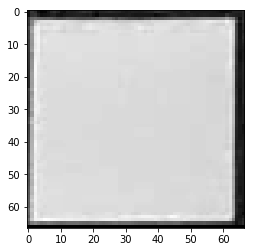

In [112]:
plt.imshow(smallboxes[6,6], cmap='gray')

In [55]:
cv2.imwrite('pic5down.jpg', downimg)

True

In [124]:
oriimg = cv2.cvtColor(cv2.imread('J.png'), cv2.COLOR_BGR2GRAY)
cv2.imwrite('J.jpg', cv2.resize(oriimg,(28,28)))

True